# <font color="yellow"> Loading the data for training and prediction </font>

In [1]:
!git clone https://github.com/Global-Classroom-Scattering-Theory/Application-of-Neural-networks-to-amplitude-analysis.git ./ANNProject

Cloning into './ANNProject'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 41 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.
Checking out files: 100% (30/30), done.


In [2]:
import os
path=os.path.expanduser("./ANNProject/dataset/")

In [3]:
import glob
import pandas as pd
import os

dfs =[]

for filename in sorted(glob.glob(path+"ln*.csv")):

    print(filename)
    dfs.append(pd.read_csv(filename,sep=";"))    

    
data=pd.concat(dfs)    

./ANNProject/dataset/ln200k65bins_part_01.csv
./ANNProject/dataset/ln200k65bins_part_02.csv
./ANNProject/dataset/ln200k65bins_part_03.csv
./ANNProject/dataset/ln200k65bins_part_04.csv
./ANNProject/dataset/ln200k65bins_part_05.csv
./ANNProject/dataset/ln200k65bins_part_06.csv
./ANNProject/dataset/ln200k65bins_part_07.csv
./ANNProject/dataset/ln200k65bins_part_08.csv
./ANNProject/dataset/ln200k65bins_part_09.csv
./ANNProject/dataset/ln200k65bins_part_10.csv
./ANNProject/dataset/ln200k65bins_part_11.csv
./ANNProject/dataset/ln200k65bins_part_12.csv
./ANNProject/dataset/ln200k65bins_part_13.csv
./ANNProject/dataset/ln200k65bins_part_14.csv
./ANNProject/dataset/ln200k65bins_part_15.csv
./ANNProject/dataset/ln200k65bins_part_16.csv
./ANNProject/dataset/ln200k65bins_part_17.csv
./ANNProject/dataset/ln200k65bins_part_18.csv
./ANNProject/dataset/ln200k65bins_part_19.csv
./ANNProject/dataset/ln200k65bins_part_20.csv
./ANNProject/dataset/ln200k65bins_part_21.csv
./ANNProject/dataset/ln200k65bins_

In [4]:
data.shape

(200000, 151)

# <font color="yellow"> Extractig columns containing the signal and background intensities</font>

In [5]:
import numpy as np

fulldataset = data

lowe=4.251 #4.101 #4.251
upe=4.379 #4.399 #4.379
widthe=0.002

longCols=["M22Sign","RS1","RS2","RS3","RS4",]
floatCols=[col for col in fulldataset.columns if col not in longCols]
fulldataset[longCols]=fulldataset[longCols].astype("long")
fulldataset[floatCols]=fulldataset[floatCols].astype("float32")
fulldataset=fulldataset[(fulldataset.RS3==4) | (fulldataset.RS3==2)]

hyperparam_cols=["p0","p1","b0","b1","M11","M22","M12SQ","M22Sign"
                 ,"Re1","Im1","RS1","Re2","Im2","RS2","Re3","Im3","RS3","Re4","Im4","RS4"]
hyperparams=fulldataset[hyperparam_cols]


x_cols=[col for col in fulldataset.columns if col not in hyperparam_cols]
e=[energy for energy in x_cols if energy[:4]=="_sig"]
e=[float(energy.split("_")[2]) for energy in e]
e=np.array([energy for energy in e if energy<=upe and energy>=lowe])
# sig_energies=["sig_"+str(energy) for energy in e]
# bkg_energies=["bkg_"+str(energy) for energy in e]
sig_c_energies=["_sig_"+str(energy) for energy in e]
bkg_c_energies=["_bkg_"+str(energy) for energy in e]

X_c=fulldataset[sig_c_energies].values+fulldataset[bkg_c_energies].values # energy resolved
# X_p=fulldataset[sig_energies].values+fulldataset[bkg_energies].values # perfect resolution
Y=np.ravel(fulldataset["classes"])

# <font color="yellow"> Adding Gaussian noise to the signal</font>

In [6]:
#  noise 
import numpy as np
import pandas as pd

mu, sigma = 0, 1 # mean and standard deviation
noiseStd = 0.05

dataX_sig = fulldataset[sig_c_energies].values
dataX_bkg = fulldataset[bkg_c_energies].values
noise = np.zeros(dataX_sig.shape)
print(dataX_sig.shape)
for i in range(dataX_sig.shape[0]):
    noise[i] = np.random.normal(mu, sigma, size=(65)) * dataX_sig[i, :].max() * noiseStd

X_noise = dataX_sig + noise
X_completed=X_noise+fulldataset[bkg_c_energies].values # energy resolved


# X = X_c
print(X_c.shape, X_completed.shape, Y.shape)

(200000, 65)
(200000, 65) (200000, 65) (200000,)


# <font color="yellow"> Scaling the training data to the [0,1] interval.
Note: usually one scales columnwise, as it is assumed that features are independent and identically distributed. Here this is not the case - adjacent data form the curve.</font>

In [7]:
from sklearn.preprocessing import minmax_scale

X_scaled = minmax_scale(X_completed, axis=1)

# <font color="yellow"> One-hot encoding</font>

In [8]:
from tensorflow.keras.utils import to_categorical

Yenc=to_categorical(Y)

# <font color="yellow">Train-test split and input reshape</font>

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Yenc, test_size=0.3,random_state=1)

X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)

In [10]:
X_train.shape

(140000, 65, 1)

# <font color="yellow">Model construction</font>

In [11]:
# Import `Sequential` from `keras.models`
import tensorflow
from tensorflow.keras.models import Sequential

# Import `Dense` from `keras.layers`
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.layers import Dropout, Flatten,MaxPooling1D

def makeModel(dropout=False):

    activation = 'relu'
    input_shape = (65,1)

    # Initialize the constructor
    model = Sequential()

    # Add an input layer 
    model.add(Conv1D(32, 3, activation = activation, padding = 'valid', input_shape = input_shape))
    model.add(MaxPooling1D(2))
    if dropout:
        model.add(Dropout(.2))
    # Add hidden layers 
    model.add(Conv1D(64, 5, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    # model.add(Conv1D(64, 5, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    model.add(MaxPooling1D(2))
    if dropout:
        model.add(Dropout(.2))

    # model.add(Conv1D(64, 7, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    # model.add(Conv1D(64, 7, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    # if dropout:
    #     model.add(Dropout(.2))        

    model.add(Conv1D(64, 7, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    # model.add(Conv1D(128, 7, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    if dropout:
        model.add(Dropout(.2))

    # model.add(Conv1D(128, 9, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    # model.add(Conv1D(128, 9, activation = activation, padding = 'valid', kernel_initializer = "he_normal"))
    # if dropout:
    #     model.add(Dropout(.2))

    # Fully connected layers
    model.add(Flatten())

    model.add(Dense(400, activation = activation, kernel_initializer = "he_normal", 
                    kernel_regularizer=tensorflow.keras.regularizers.l1(0.01),
                    activity_regularizer=tensorflow.keras.regularizers.l2(0.01)))
    if dropout:
        model.add(Dropout(.2))

    model.add(Dense(200, activation = activation, kernel_initializer = "he_normal", 
                    kernel_regularizer=tensorflow.keras.regularizers.l1(0.01),
                    activity_regularizer=tensorflow.keras.regularizers.l2(0.01)))
    if dropout:
        model.add(Dropout(.5))
    
    # Add an output layer
    model.add(Dense(4, activation = 'softmax')) # 4 classes
    
    return model



model=makeModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 63, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 31, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 64)             28736     
                                                                 
 flatten (Flatten)           (None, 448)               0

# <font color="yellow">Model training</font>

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
history=model.fit(X_train, Y_train,epochs=100,batch_size=1024, validation_split=.25, verbose=1)

try:
  import cPickle as pickle
except:
  import pickle

pickle.dump(history.history,open("CNN-LN_DS.pck","wb"))

model.save("CNN-LN_DS.mod")

Epoch 1/100
103/103 [==============================] - 13s 16ms/step - loss: 59.8776 - accuracy: 0.7140 - val_loss: 9.9728 - val_accuracy: 0.7639
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 2.7118 - accuracy: 0.8262 - val_loss: 1.0009 - val_accuracy: 0.8758
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.9438 - accuracy: 0.8816 - val_loss: 0.9044 - val_accuracy: 0.8838
Epoch 4/100
103/103 [==============================] - 1s 13ms/step - loss: 0.8735 - accuracy: 0.8915 - val_loss: 0.8504 - val_accuracy: 0.8959
Epoch 5/100
103/103 [==============================] - 1s 10ms/step - loss: 0.8321 - accuracy: 0.8960 - val_loss: 0.8104 - val_accuracy: 0.9000
Epoch 6/100
103/103 [==============================] - 1s 10ms/step - loss: 0.7958 - accuracy: 0.9017 - val_loss: 0.7788 - val_accuracy: 0.9073
Epoch 7/100
103/103 [==============================] - 1s 10ms/step - loss: 0.7723 - accuracy: 0.9031 - val_loss: 0.7584 - val_accurac

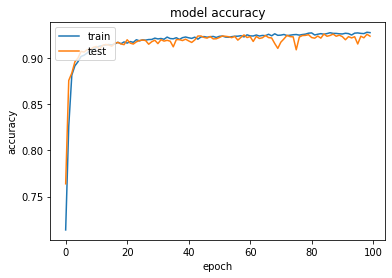

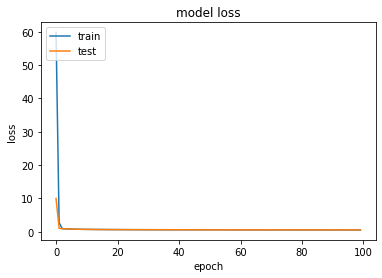

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import tensorflow.keras as kr

try:
  import cPickle as pickle
except:
  import pickle

pickled_hist=pickle.load(open("CNN-LN_DS.pck","rb")) 


loaded_model=kr.models.load_model("CNN-LN_DS.mod")

model=loaded_model
# summarize history for accuracy
plt.plot(pickled_hist['accuracy'])
plt.plot(pickled_hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(pickled_hist['loss'])
plt.plot(pickled_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# <font color="yellow">Loading data for prediction</font>

In [14]:
import pandas as pd
weight_ds=pd.read_csv(path+"boot_weight.csv",sep=";")
all_ds=pd.read_csv(path+"boot_all.csv",sep=";")
kp_ds=pd.read_csv(path+"boot_kp.csv",sep=";")

# <font color="yellow">Prediction</font>

In [15]:
from sklearn.preprocessing import minmax_scale

np.expand_dims(minmax_scale(weight_ds, axis=1),-1)

y_pred_weight=model.predict(np.expand_dims(minmax_scale(weight_ds, axis=1),-1))

y_pred_all=model.predict(np.expand_dims(minmax_scale(all_ds, axis=1),-1))

y_pred_kp=model.predict(np.expand_dims(minmax_scale(kp_ds, axis=1),-1))

In [16]:
lab_weight=y_pred_weight.argmax(axis=1)
lab_all=y_pred_all.argmax(axis=1)
lab_kp=y_pred_kp.argmax(axis=1)

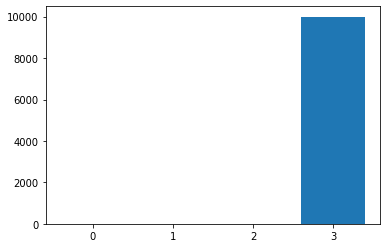

In [17]:
%matplotlib inline
# from matplotlib import pyplot as plt
# plt.hist(lab_weight,bins=4,range=(0,3))
# plt.show()

labels, counts = np.unique(lab_weight, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks([0,1,2,3])
plt.show()

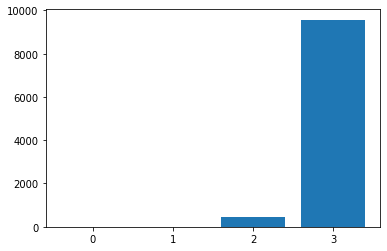

In [18]:
%matplotlib inline
# from matplotlib import pyplot as plt
# plt.hist(lab_all)
# plt.show()

labels, counts = np.unique(lab_all, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks([0,1,2,3])
plt.show()

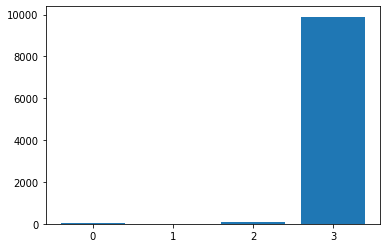

In [19]:
%matplotlib inline
# from matplotlib import pyplot as plt
# plt.hist(lab_kp)
# plt.show()

labels, counts = np.unique(lab_kp, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks([0,1,2,3])
plt.show()

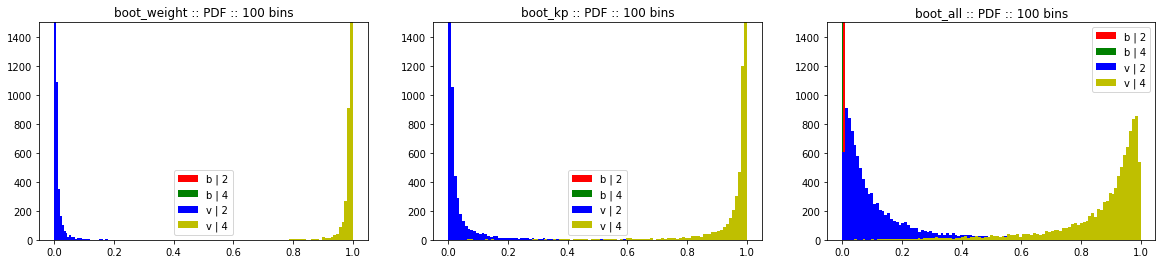

In [20]:
from matplotlib import pyplot as plt 
import numpy as np  

# ########################################################################### 
# probability distributions of predictions for different experimental dataset
# ###########################################################################

idx = 1
series = ['boot_weight', 'boot_kp', 'boot_all']
bins = 100
colors = ['r', 'g', 'b', 'y']
classes = ['b | 2','b | 4','v | 2','v | 4']
plt.figure(figsize=(20,4))
for f in [y_pred_weight, y_pred_kp, y_pred_all]:
  # plt.figure(figsize=(20,4))
  plt.subplot(1,3,idx)

  ymax = 1500
  ax = plt.gca()
  # ax.set_xlim([xmin, xmax])
  ax.set_ylim([None, ymax])

  for i in [0,1,2,3]:   
    plt.hist(f[:,i], bins = bins, color=colors[i]) 
    plt.title(series[idx-1] + " :: PDF :: " + str(bins) + " bins") 
    plt.legend(classes)
  idx += 1
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')